# Hood Snow Exploratory Data Analysis

This notebook is kinda a mess and probably won't work unless all the previous steps (data download and processing) are redone to put all the rasters and such in their respective places.

Really, this notebook was my scratch space while I was figuring out what and how to deal with the snow coverage (and other) data. It's real outputs are `prepared_data.csv` and `prepared_weather.csv` which are the only inputs to the cleaned up notebook in `vizualization.ipynb`.

In [123]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date
sb.set_theme()

DATA = Path("E:/sensing/hood_snow/data").resolve()

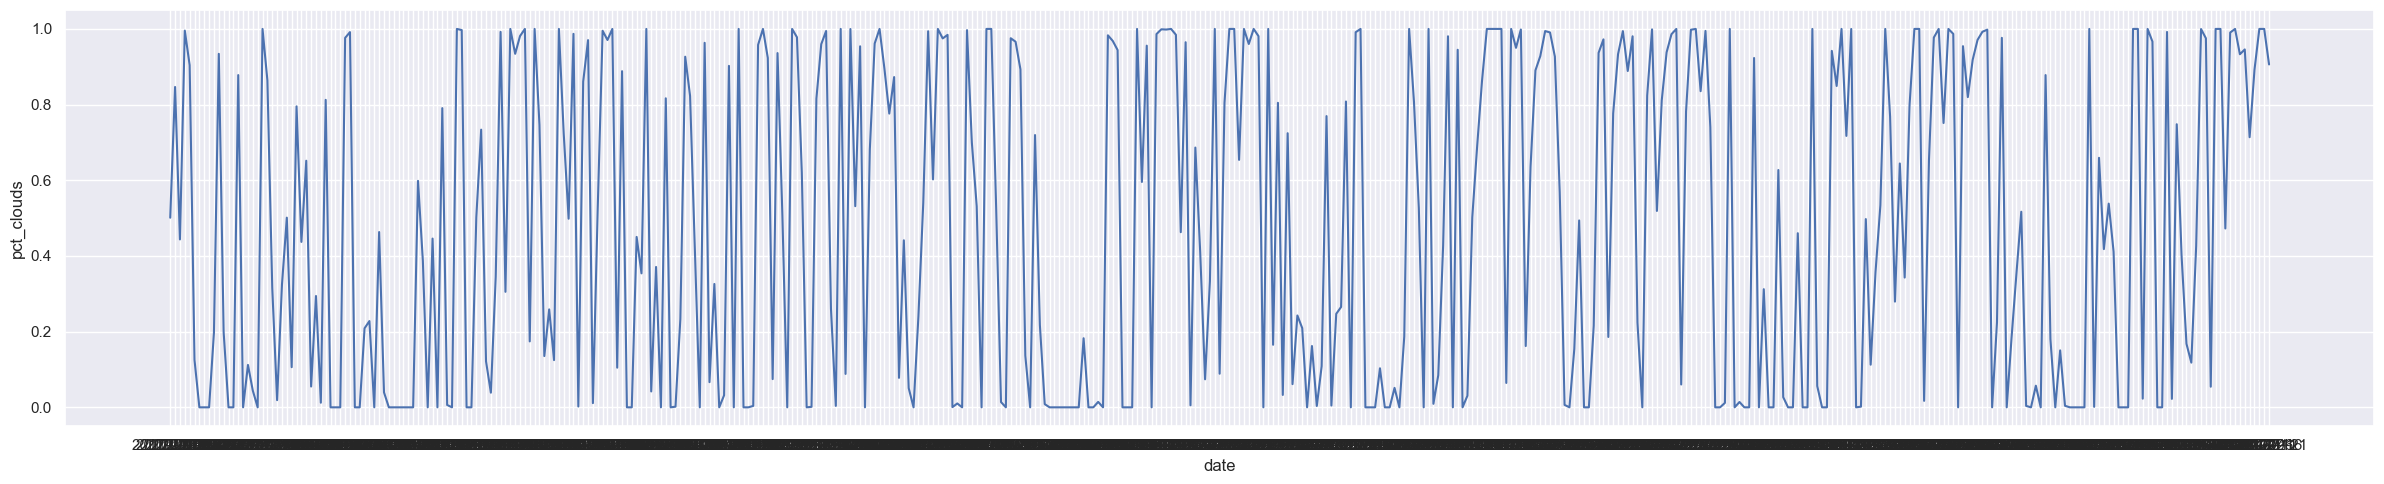

In [124]:
# visualize the cloud percent (from CLM) over time
clouds = pd.read_csv(DATA.joinpath("clouds.csv"))
clouds = clouds.rename(columns={"mean":"pct_clouds"})
# there are a few days where some of the CLM bands had 255 for
# some pixels instead of just 0 or 1
clouds = clouds.drop(clouds.loc[clouds["pct_clouds"] > 1].index)
# clouds["date"] = pd.to_datetime(clouds["date"])
clouds = clouds.set_index("date")
ax: plt.Axes = sb.lineplot(clouds, x="date", y="pct_clouds")
ax.figure.set_size_inches(w=24, h=5)
plt.tight_layout()

In [125]:
# read the snow data from all the individual csv files generated for
# each mask by the too_calculate_pct_snow script.
# concatenate all data into one dataframe, add date column.
files = list(DATA.joinpath("images").glob("*_masks.csv"))
dates = sorted([p.name.removesuffix("_masks.csv") for p in files])
frames = [pd.read_csv(f).assign(date=d) for d, f in zip(dates, files)]
data = pd.concat(frames, ignore_index=True)

# CLEAN
# levels below 1200m aren't significant since I created the AOI from 1500m
data = data.drop(data.loc[data.contour_min <= 1200].index)
# this one particular date's images are misaligned, so it's bad data
data = data.drop(data.loc[data["date"] == "2018-08-16"].index)

# set appropriate dtypes
data = data.astype({"contour_min": int, "contour_max": int})

# join cloud coverage
data = data.merge(clouds["pct_clouds"], on="date")


# write to file
# data.to_csv(DATA.joinpath("full_dataset.csv"), index=False)

data.head()

,contour_min,contour_max,snow_COUNT,snow_AREA,snow_SUM,usable_COUNT,usable_AREA,usable_SUM,usable_snow_COUNT,usable_snow_AREA,usable_snow_SUM,pct_snow,pct_usable,pct_usable_snow,date,pct_clouds
0,1300,1400,201182.0,2.012762e+07,39554.0,201182.0,2.012762e+07,11697.0,201182.0,2.012762e+07,7322.0,0.196608,0.058141,0.625972,2017-01-03,0.501097
1,1400,1500,224718.0,2.248233e+07,47035.0,224718.0,2.248233e+07,19713.0,224718.0,2.248233e+07,12211.0,0.209307,0.087723,0.619439,2017-01-03,0.501097
2,1500,1600,242721.0,2.428347e+07,58444.0,242721.0,2.428347e+07,22320.0,242721.0,2.428347e+07,16103.0,0.240787,0.091957,0.721461,2017-01-03,0.501097
3,1600,1700,207290.0,2.073871e+07,53214.0,207290.0,2.073871e+07,24590.0,207290.0,2.073871e+07,18314.0,0.256713,0.118626,0.744774,2017-01-03,0.501097
4,1700,1800,154735.0,1.548075e+07,58598.0,154735.0,1.548075e+07,31524.0,154735.0,1.548075e+07,25472.0,0.378699,0.203729,0.808019,2017-01-03,0.501097


In [126]:
# save just the important columns to be joined with contour_rings feature class in arcpro
mini = data[["date", "contour_min", "pct_usable_snow", "pct_clouds"]]
mini = mini.rename(columns={
    "contour_min": "contour",
    "pct_usable_snow": "pct_snow",
    # "mean_clouds": "pct_clouds",
})
mini = mini.round(3)
# mini.to_csv(DATA.joinpath("prepared_data.csv"), index=False)
mini.head()

,date,contour,pct_snow,pct_clouds
0,2017-01-03,1300,0.626,0.501
1,2017-01-03,1400,0.619,0.501
2,2017-01-03,1500,0.721,0.501
3,2017-01-03,1600,0.745,0.501
4,2017-01-03,1700,0.808,0.501


In [127]:
def drop_clouds(data: pd.DataFrame, max_clouds_pct: float = 1, pct_clouds_col: str = "pct_clouds") -> pd.DataFrame:
    """Drop data with percent cloud coverage greater than `max_clouds`."""
    return data.drop(data.loc[data[pct_clouds_col] > max_clouds_pct].index)  # drop cloudy days

In [128]:
# t = drop_clouds(data, 0.4)
# t[t["date"].str.startswith("2018-08")]["date"].unique()

In [129]:
# pivot data into a form suitable for date-wise analysis
data_rect = drop_clouds(data, 0.4).pivot(index="date", columns="contour_min", values="pct_usable_snow")
data_rect.head()

contour_min,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,...,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400
date,,,,,,,,,,,,,,,,,,,,,
2017-05-03,0.941371,0.933057,0.919268,0.901593,0.901385,0.926432,0.934233,0.971080,0.966135,0.972279,...,0.988449,0.991058,0.983191,0.980260,0.991865,0.962797,0.950653,0.971026,0.954622,0.931677
2017-05-23,0.882227,0.940676,0.958254,0.955816,0.960998,0.969156,0.970990,0.974557,0.971289,0.973898,...,0.976808,0.984563,0.980331,0.968942,0.982688,0.968495,0.943276,0.966787,0.961702,0.962963
2017-07-02,0.053763,0.101598,0.206849,0.338637,0.645756,0.763097,0.805210,0.838955,0.864656,0.898544,...,0.953735,0.964584,0.955793,0.960445,0.953641,0.921744,0.902584,0.897950,0.932267,0.953947
2017-07-17,0.018467,0.032217,0.062316,0.028063,0.244075,0.504584,0.643972,0.718209,0.776242,0.832658,...,0.921331,0.944643,0.950118,0.948447,0.933914,0.882506,0.852551,0.862565,0.888641,0.824817
2017-07-22,0.006828,0.019023,0.026203,0.012991,0.126306,0.303643,0.552795,0.599596,0.607145,0.655146,...,0.791217,0.837711,0.897208,0.829528,0.835705,0.835839,0.789969,0.802204,0.822961,0.668790


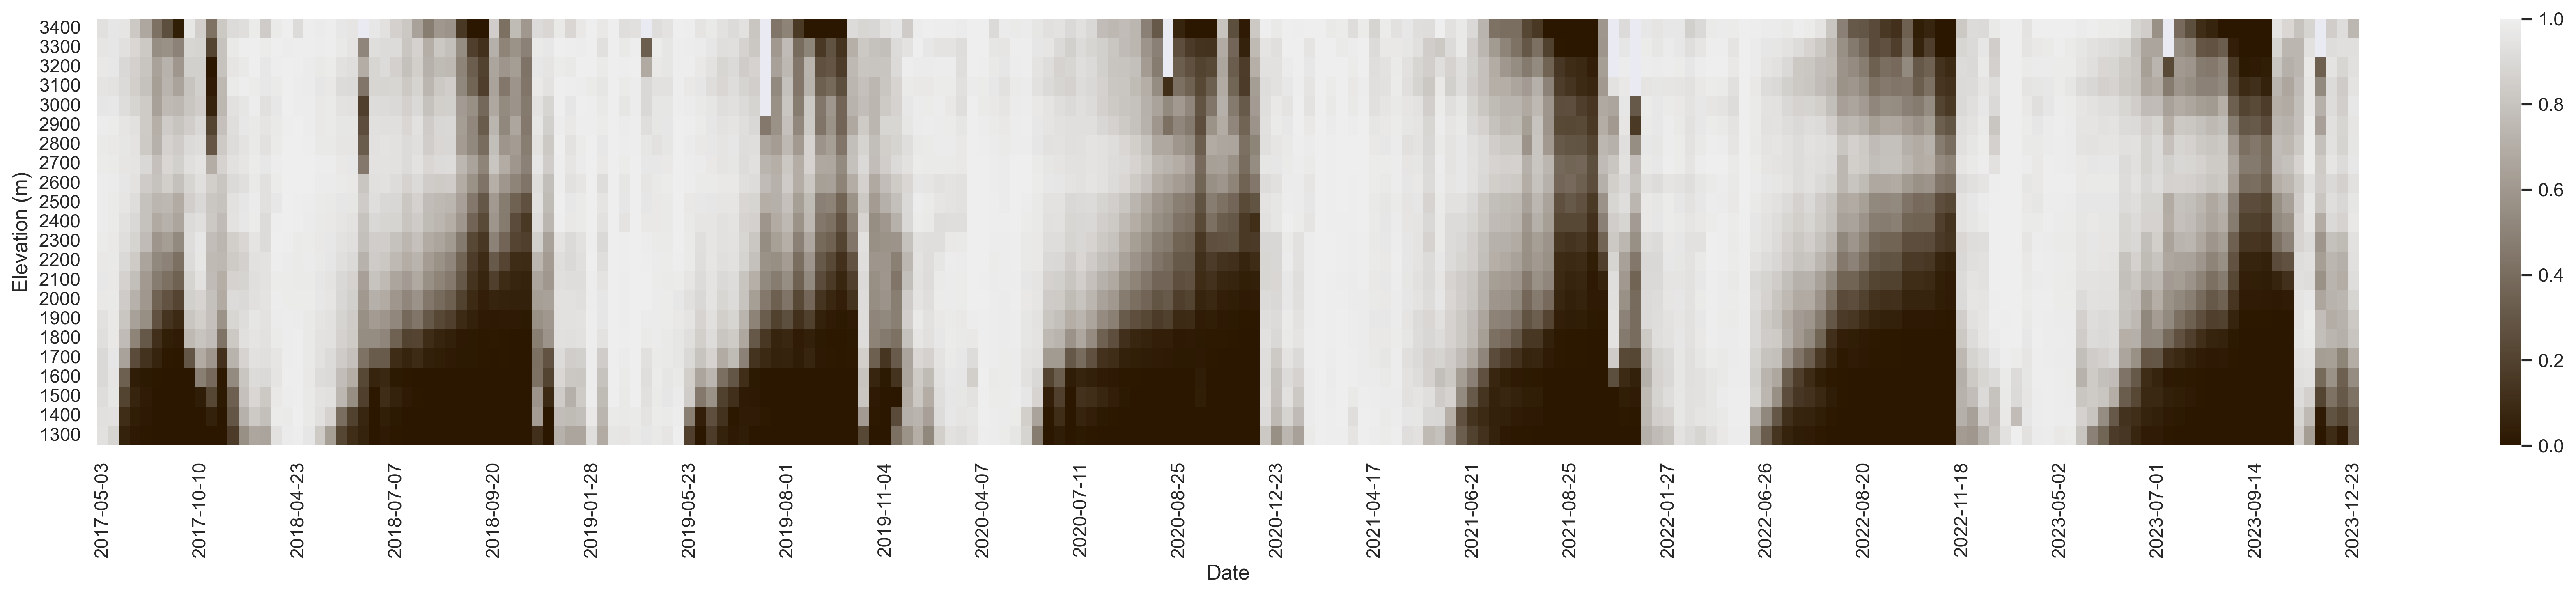

In [130]:
# create timeseries heatmap illustrating the percent snow at each contour level
# note the usually "full snow" in winter and the very clear change in snow level
# in summer, about may-sept.
data_heatmap = data_rect.transpose().sort_index(axis=0, ascending=False)
pal_white_brown = sb.color_palette("blend:#2B1700,#EEE", as_cmap=True)
ax: plt.Axes = sb.heatmap(data_heatmap, cmap=pal_white_brown)
ax.figure.set_size_inches(w=24, h=5)
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Date")
# ax.figure.set_facecolor("#111")
ax.figure.set_dpi(300)
# plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("media/heatmap.svg", transparent=True)

In [131]:
def format_date_ticks(old_ticks: list[plt.Text], fmt: str = "%Y-%m") -> list[str]:
    text = [l.get_text() for l in old_ticks]
    return pd.to_datetime(text).strftime(fmt)


def create_heatmap(data: pd.DataFrame,
                   max_cloud_pct: float = 1,
                   date_col: str = "date", contour_col: str = "contour", pct_snow_col: str = "pct_snow",
                   ax: plt.Axes = None, cmap="viridis") -> plt.Axes:
    fewer_clouds = drop_clouds(data, max_cloud_pct)
    data_heatmap = fewer_clouds.pivot(index=contour_col, columns=date_col,
                                      values=pct_snow_col).sort_index(axis=0, ascending=False)
    # sb.color_palette("blend:#2B1700,#FFF", as_cmap=True))
    ax = sb.heatmap(data_heatmap, cmap=cmap, ax=ax)
    ax.set_xticklabels(format_date_ticks(ax.get_xticklabels()))
    ax.set_title(f"Cloud Cover ≤ {max_cloud_pct*100:.0f}%")
    ax.set_ylabel("Contour elevation (m)")
    ax.set_xlabel("Date")
    return ax

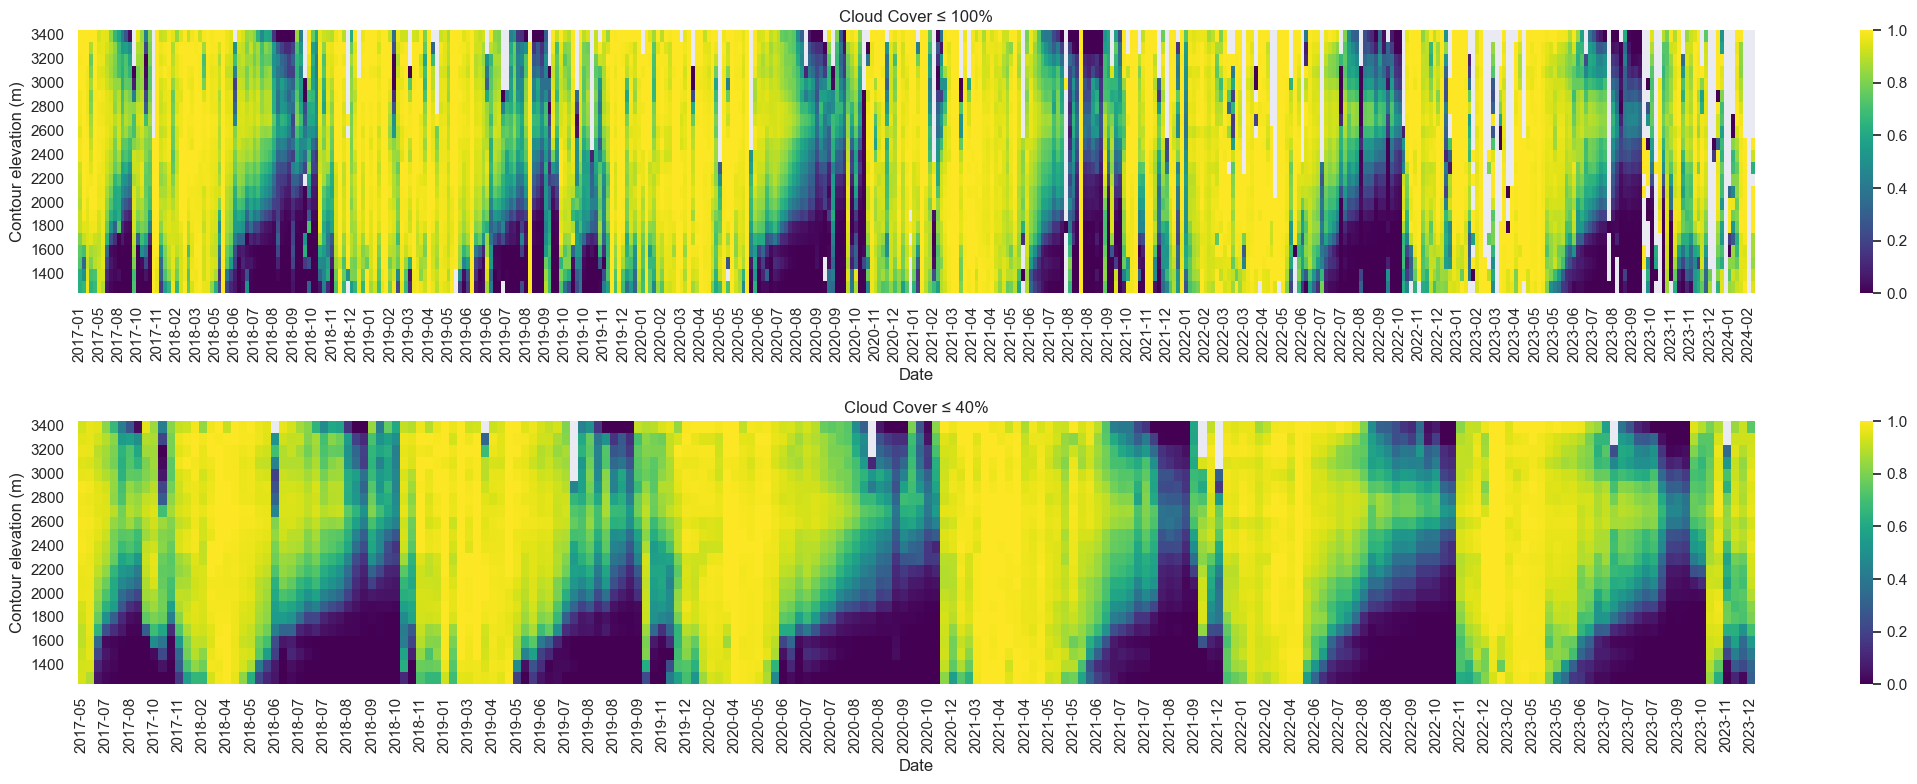

In [132]:
# data_temporal = data.copy()
# data_temporal["date"] = pd.to_datetime(data_temporal["date"]+"T19:11:00Z")

# cloud_cutoffs = [pct/100 for pct in range(100,0,-50)]
cloud_cutoffs = [1, 0.4]

fig, axes = plt.subplots(nrows=len(cloud_cutoffs), ncols=1)
fig.set_size_inches(w=22, h=len(cloud_cutoffs)*4)
for i, max_cloud_pct in enumerate(cloud_cutoffs):
    # create_heatmap(data, "date", "contour_min", "pct_usable_snow",max_cloud_pct, axes[i])
    create_heatmap(mini, max_cloud_pct=max_cloud_pct, ax=axes[i])
    # extent = axes[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # plt.savefig(f"media/heatmap_{i:02d}.png", bbox_inches=extent.expanded(1.1,1.2))
plt.tight_layout()

In [133]:
# find the contour level at which the snow level first falls below some
# "critical" percentage. 0.3 or 0.4 seem to be fine.
# __ this is the "snowline" __
def find_snowline_elevation(data: pd.DataFrame, critical_snow_pct: float,
                            date_col: str = "date", contour_col: str = "contour", snow_col: str = "pct_snow") -> pd.DataFrame:
    reshaped = data.pivot(index=date_col, columns=contour_col, values=snow_col)
    critical_levels = []
    for date in reshaped.index:
        # help smooth data
        # for each contour level, take the mean of the next lower to next higher
        # this is a 2D "focal statistic"
        # actually don't. doesn't seem to help at all
        window_mean = reshaped.loc[date]  # .rolling(window=3, center=True).mean()
        # idxmax() is weird here, but since True is max of bool, this finds the
        # index of the first True
        level = window_mean.gt(critical_snow_pct).idxmax()
        critical_levels.append((date, level, critical_snow_pct))

    return pd.DataFrame(critical_levels, columns=["date", "contour", "critical"])


# pct_snow_critical = [0.4]  # [x/10 for x in range(2,7)]

# critical_levels = []
# for date in dates:
#     if date not in data_rect.index:
#         continue
#     # help smooth data
#     # for each contour level, take the mean of the next lower to next higher
#     # this is a 2D "focal statistic"
#     window_mean = data_rect.loc[date]#.rolling(window=3, center=True, min_periods=1).mean()
#     # display(window_mean)
#     # idxmax() is weird here, but since True is max of bool, this finds the
#     # index of the first True
#     for crit in pct_snow_critical:
#         level = window_mean.gt(crit).idxmax()
#         critical_levels.append((pd.to_datetime(date), level, crit))
#     # level = window_mean.idxmax()
#     # critical_levels.append((pd.to_datetime(date), level, 0.0))

# # overwrite old levels var
# levels = pd.DataFrame(critical_levels, columns=["date", "contour", "critical"])
# levels.head()

levels = find_snowline_elevation(drop_clouds(mini, 0.4), 0.4)
levels.head()

,date,contour,critical
0,2017-05-03,1300,0.4
1,2017-05-23,1300,0.4
2,2017-07-02,1700,0.4
3,2017-07-17,1800,0.4
4,2017-07-22,1900,0.4


C:\Users\Ben\AppData\Local\Temp\ipykernel_18448\1808997194.py:2: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  ax: plt.Axes = sb.lineplot(levels[levels["date"].str.startswith("2020")], x="date", y="contour",


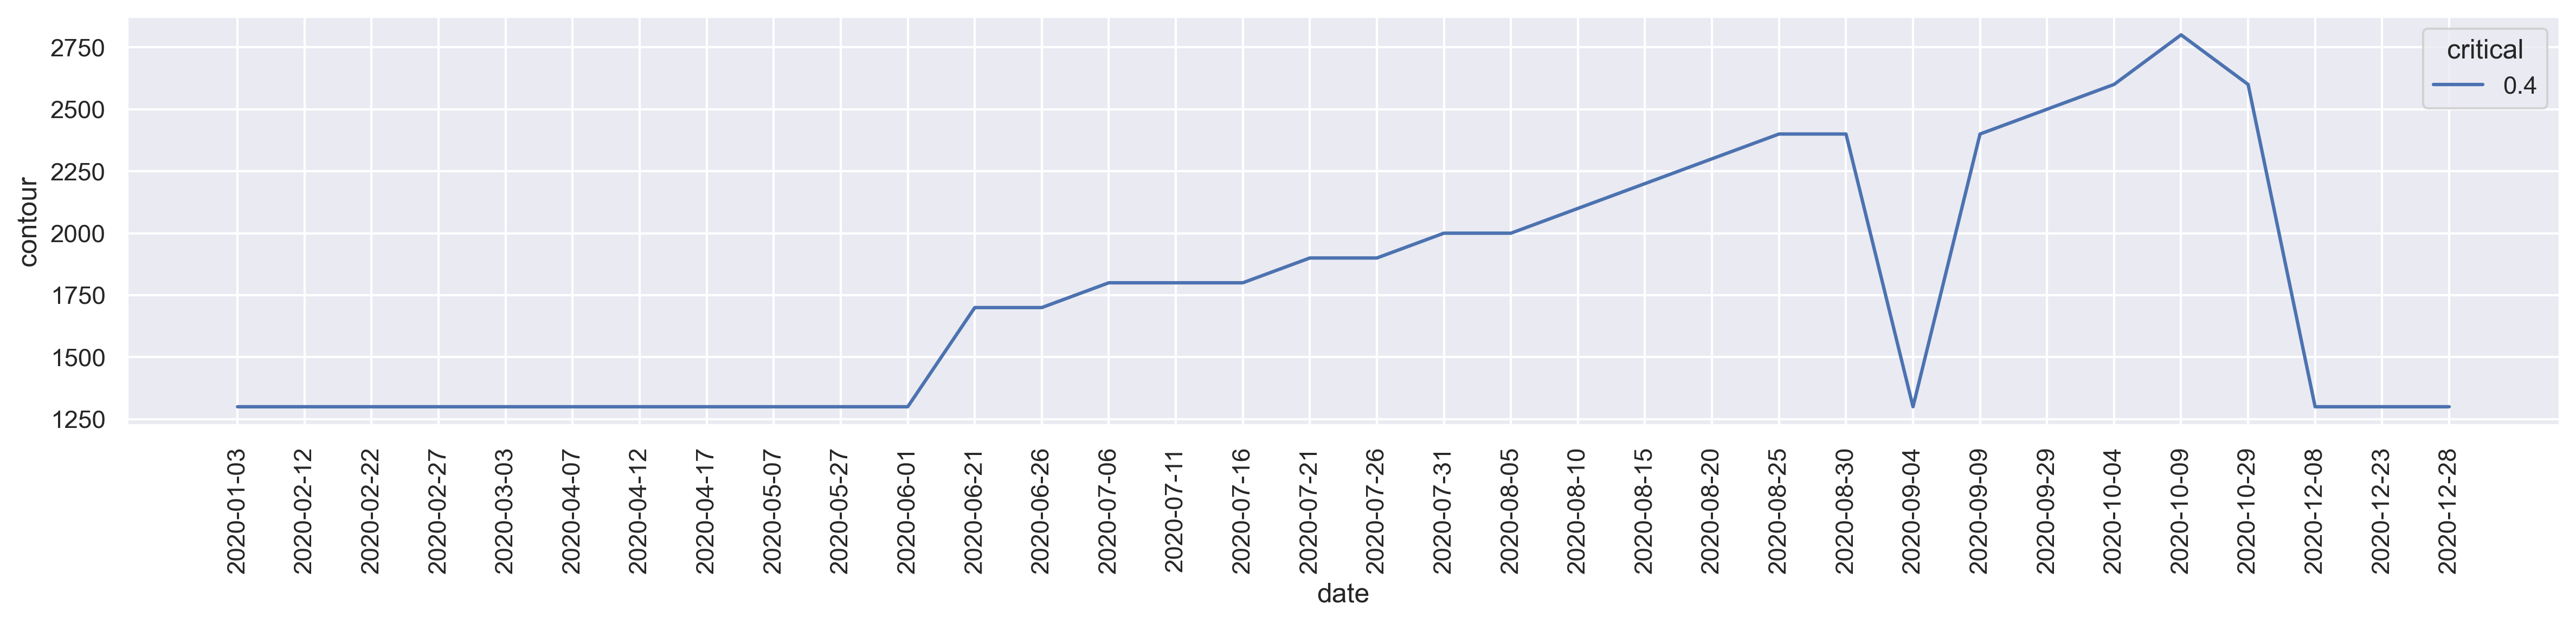

In [154]:
# plot snowline over time
ax: plt.Axes = sb.lineplot(levels[levels["date"].str.startswith("2020")], x="date", y="contour",
                           hue="critical", palette=sb.color_palette())
ax.figure.set_size_inches(w=16, h=4)
ax.figure.set_dpi(300)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
def calc_snowline_movement(data_levels: pd.DataFrame, min_contour: int = 1300,
                           date_col: str = "date", contour_col: str = "contour") -> pd.DataFrame:
    levels = data_levels.copy()
    levels["year"] = pd.to_datetime(levels[date_col]).dt.year

    def year_snowline_movement(year: int) -> pd.Series:
        begin_idx = levels[levels["year"] == year][contour_col].gt(min_contour).idxmax()
        end_idx = levels[levels["year"] == year][contour_col].idxmax()
        begin = pd.to_datetime(levels.loc[begin_idx, date_col])
        end = pd.to_datetime(levels.loc[end_idx, date_col])
        span = end - begin
        low = levels.loc[begin_idx, contour_col]
        high = levels.loc[end_idx, contour_col]
        elev_diff = high - low
        return pd.Series({
            "year": year,
            "begin": begin,
            "end": end,
            "span": span,
            "low": low,
            "high": high,
            "elev_diff": elev_diff,
            "rate": elev_diff/span.days})

    return pd.DataFrame([year_snowline_movement(year)
                         for year in levels["year"].unique()])


snowline_movement = calc_snowline_movement(levels)
snowline_movement

,year,begin,end,span,low,high,elev_diff,rate
0,2017,2017-07-02,2017-08-31,60 days,1700,2200,500,8.333333
1,2018,2018-05-28,2018-09-05,100 days,1400,2600,1200,12.000000
2,2019,2019-05-23,2019-09-05,105 days,1400,2600,1200,11.428571
3,2020,2020-06-21,2020-10-09,110 days,1700,2800,1100,10.000000
4,2021,2021-06-16,2021-09-24,100 days,1500,2400,900,9.000000
5,2022,2022-06-26,2022-09-24,90 days,1400,2600,1200,13.333333
6,2023,2023-06-01,2023-09-09,100 days,1400,2700,1300,13.000000


<AxesSubplot: xlabel='year', ylabel='rate'>

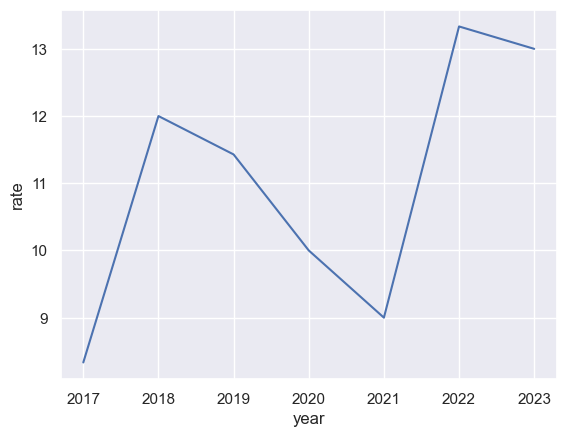

In [ ]:
sb.lineplot(snowline_movement, x="year", y="rate")

# snowtel

In [ ]:
# import mt hood snowtel data
snowtel = pd.read_csv(DATA.joinpath("hood_snowtel_651_1980-2024.csv"), skiprows=1)
snowtel["date"] = pd.to_datetime(snowtel["date"])
snowtel = snowtel.set_index("date")
snowtel = snowtel.loc["2017-01-03":"2024-02-21",:] # reduce data to just the study period
snowtel = snowtel.assign(place="Snotel") # set place to match ski weather stations
snowtel.head()

,snow_water,precip,temp_max,temp_min,temp_avg,precip_inc,place
date,,,,,,,
2017-01-03,26.0,48.3,15.1,9.9,12.4,0.0,Snotel
2017-01-04,25.6,48.3,17.6,9.0,14.0,0.0,Snotel
2017-01-05,24.2,48.3,25.3,15.6,20.7,0.0,Snotel
2017-01-06,24.2,48.3,31.5,13.1,23.5,0.0,Snotel
2017-01-07,24.2,48.3,33.6,12.6,20.8,0.3,Snotel


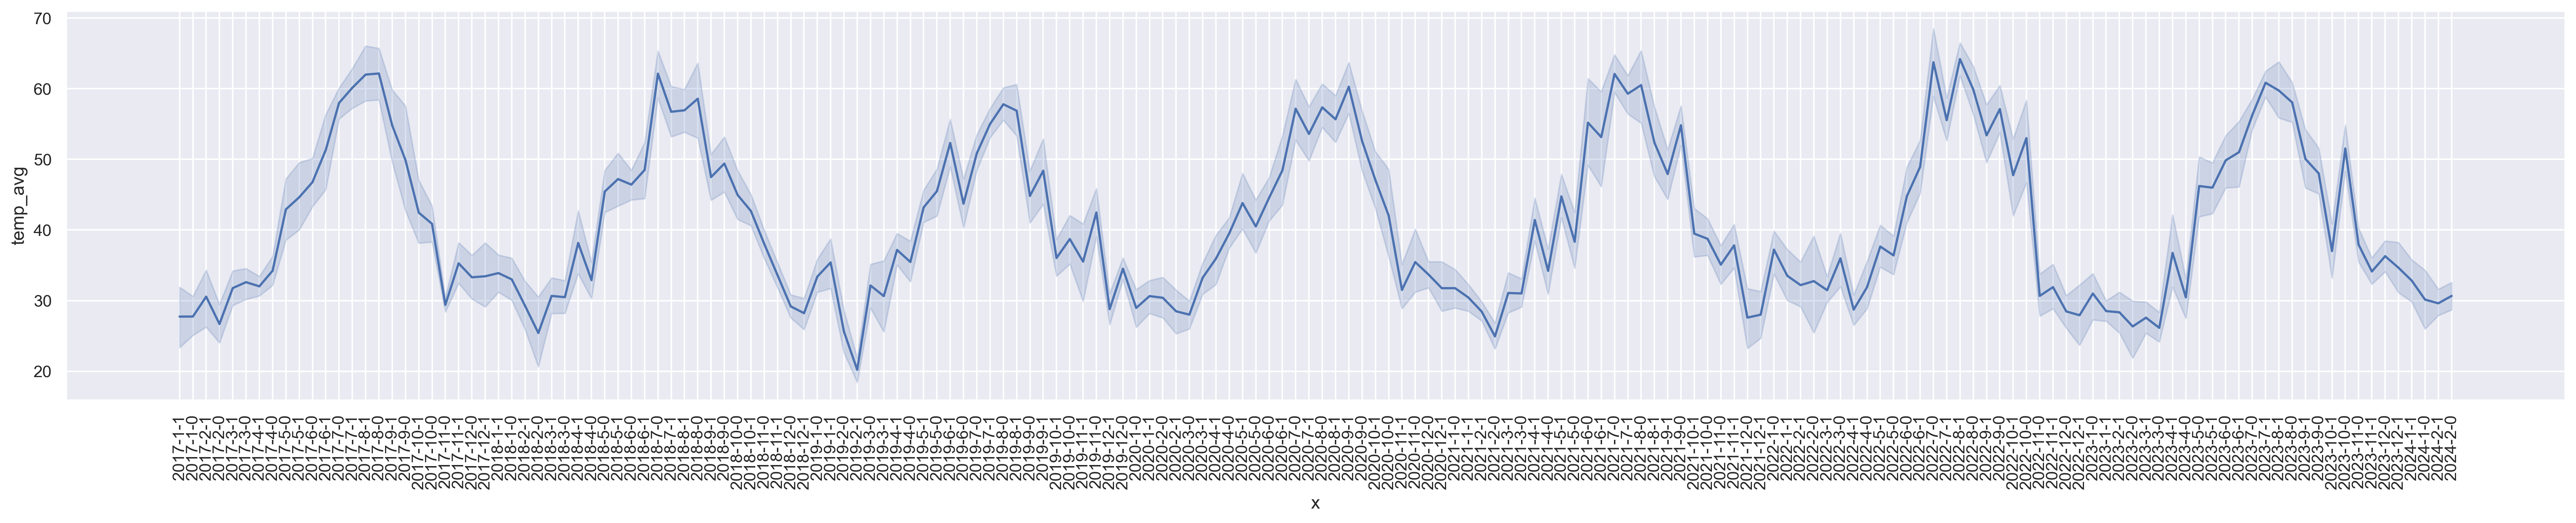

In [ ]:
# plot snowtel data over time
# snowtel["x"] = snowtel.index.strftime("%Y-%m")
snowtel["x"] = snowtel.index.map(lambda r: f"{r.year}-{r.month}-{pd.to_numeric(r.strftime('%W'))%2}")
ax: plt.Axes = sb.lineplot(snowtel, x="x", y="temp_avg")
ax.figure.set_size_inches(w=24, h=5)
ax.figure.set_dpi(300)
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("media/temp.svg",transparent=True)

# ski resort weather

In [ ]:
def split_weather(filename: Path) -> tuple[str, int, int]:
    name, elev, year = filename.stem.split("_")  # resort-lift_elevation_year
    name = name.split("-")[1]  # remove resort name
    return (name, int(elev), int(year))


def prepare_weather(filename: Path) -> pd.DataFrame:
    place, elev, year = split_weather(filename)
    d = pd.read_csv(filename).assign(place=place, elevation=elev, year=year)
    d = d.rename(columns={
        "Date/Time (PST)": "datehour",
        "Battery Voltage  (v) ": "battery",
        "Relative Humidity  (%) ": "rel_humidity",
        "Temperature  (deg F) ": "temp",
        "Wind Direction  (deg.) ": "wind_dir",
        "Wind Speed Average  (mph) ": "wind_spd_avg",
        "Wind Speed Maximum  (mph) ": "wind_spd_max",
        "Wind Speed Minimum  (mph) ": "wind_spd_min",
        'Total Snow Depth  (") ': "snow_depth",
        '24 Hour Snow  (") ': "snow_24hr",
        'Precipitation  (") ': "precip"})
    d["datehour"] = pd.to_datetime(d["datehour"] + "-08:00")  # all dates are in fact PST
    d["date"] = d["datehour"].dt.date
    return d


frames = [prepare_weather(p) for p in DATA.joinpath("weather").glob("*.csv")]
ski_weather = pd.concat(frames, ignore_index=True)
ski_weather = ski_weather.sort_values(["place", "datehour"])

# ski_weather.drop(columns=["date", "year", "battery"]).to_csv(DATA.joinpath("ski_telem_2017-2024.csv"), index=False)

In [ ]:
def drop_percent(data: pd.DataFrame, column: str, low_pct: float = 0.01, high_pct: float = 0.99) -> pd.DataFrame:
    low = data[column].quantile(low_pct)
    high = data[column].quantile(high_pct)
    print(f"low={low}, high={high}")
    return data[(low < data[column]) & (data[column] < high)]


# drop lowest 0.1% of temp, then aggregate hourly data by day
weather_day = (drop_percent(ski_weather, "temp", 0.001, 1)
               .groupby(["place", "date"])
               .apply(lambda g: pd.Series({
                   ("temp_avg"): g.temp.mean(),
                   ("temp_min"): g.temp.min(),
                   ("temp_max"): g.temp.max(),
                   ("precip"): g.precip.sum(),
                   ("snow_depth"): g.snow_depth.max(),
               }).round(1)))

weather_day

low=-0.545239, high=95.9


temp_avg  temp_min  temp_max  precip  snow_depth
place     date                                                        
Blue      2017-01-01      11.5       8.5      13.7     0.0         NaN
          2017-01-02       4.9       2.4       7.6     0.0         NaN
          2017-01-03       3.8       0.9       9.8     0.0         NaN
          2017-01-04       2.4      -0.5       6.2     0.0         NaN
          2017-01-05      14.1       2.7      26.9     0.0         NaN
...                        ...       ...       ...     ...         ...
MagicMile 2024-03-05      17.0       9.8      28.8     0.0         NaN
          2024-03-06      16.0       8.9      26.8     0.0         NaN
          2024-03-07      23.5      16.0      32.0     0.0         NaN
          2024-03-08      31.8      25.4      41.3     0.0         NaN
          2024-03-09      26.9      20.2      31.2     0.0         NaN

[9985 rows x 5 columns]

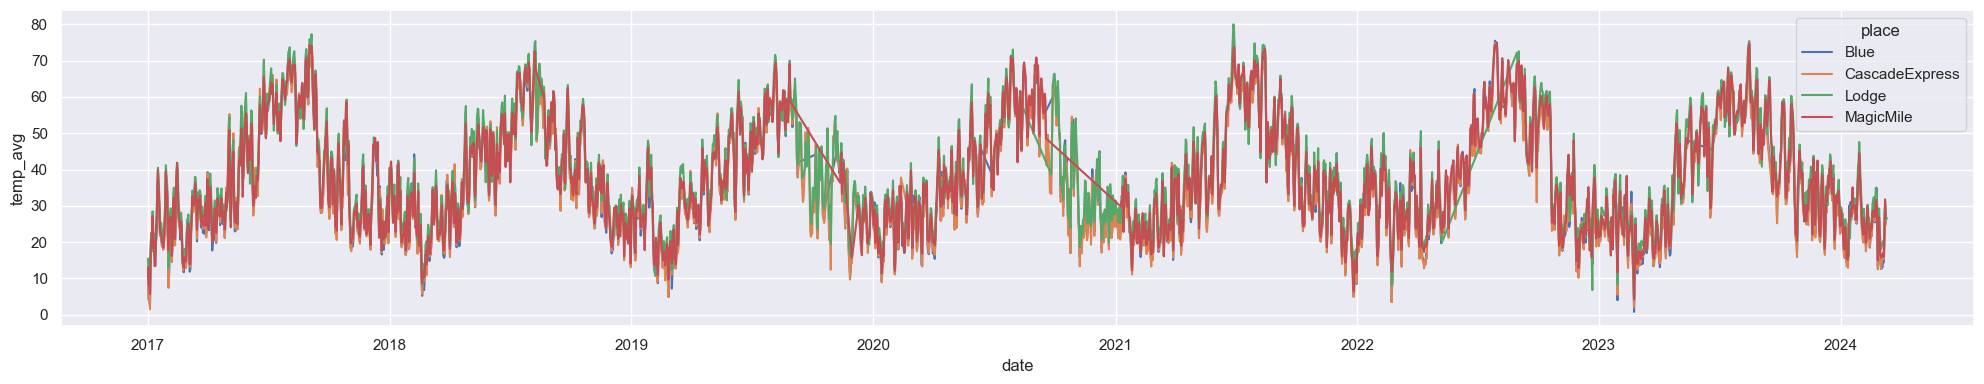

In [ ]:
ax: plt.Axes = sb.lineplot(weather_day.reset_index(), x="date", y="temp_avg", hue="place")
ax.figure.set_size_inches(w=20, h=4)
plt.tight_layout()

# join snowtel and ski resort weather

In [ ]:
temp_snowtel = snowtel.reset_index()
temp_snowtel["date"] = temp_snowtel["date"].dt.date

all_weather: pd.DataFrame = pd.concat([
    temp_snowtel[["place", "date", "precip", "temp_avg", "temp_min", "temp_max", "snow_water"]],
    weather_day.reset_index(),
])

# assign elevations (in meters) to locations
all_weather["elev"] = all_weather["place"].apply(lambda p: {
    "Snotel": 1635,
    "Blue": 1995,
    "CascadeExpress": 2225,
    "Lodge": 1770,
    "MagicMile": 2130,
}[p])
all_weather.head()
# all_weather.to_csv(DATA.joinpath("prepared_weather.csv"), index=False)

,place,date,precip,temp_avg,temp_min,temp_max,snow_water,snow_depth,elev
0,Snotel,2017-01-03,48.3,12.4,9.9,15.1,26.0,NaN,1635
1,Snotel,2017-01-04,48.3,14.0,9.0,17.6,25.6,NaN,1635
2,Snotel,2017-01-05,48.3,20.7,15.6,25.3,24.2,NaN,1635
3,Snotel,2017-01-06,48.3,23.5,13.1,31.5,24.2,NaN,1635
4,Snotel,2017-01-07,48.3,20.8,12.6,33.6,24.2,NaN,1635


In [155]:
weather = pd.read_csv(DATA.joinpath("prepared_weather.csv"))
weather = weather.drop(weather[weather.snow_depth >= 250].index)


def find_no_snow_date(weather: pd.DataFrame, snow_amount_col: str = "snow_water", amount_cutoff: float = 25,  date_col: str = "date") -> pd.DataFrame:
    # amount_cutoff=1 works ok for snow_water (snotel)
    # amount_cutoff=25 works ok for snow_depth (lodge)
    w = weather.drop(index=weather[weather[snow_amount_col].isna()].index)
    w["year"] = pd.to_datetime(w[date_col]).dt.year
    found = []
    for y in w["year"].unique():
        first = w[w["year"] == y][snow_amount_col].lt(amount_cutoff).idxmax()
        found.append(w.loc[first][["year", "date", snow_amount_col, "place", "elev"]])
    return pd.DataFrame(found)


display(find_no_snow_date(weather, "snow_depth"))

,year,date,snow_depth,place,elev
7915,2017,2017-07-16,21.1,Lodge,1770
8258,2018,2018-06-24,22.4,Lodge,1770
8617,2019,2019-06-18,24.1,Lodge,1770
9000,2020,2020-07-05,24.2,Lodge,1770
9315,2021,2021-06-27,23.4,Lodge,1770
9632,2022,2022-08-30,3.8,Lodge,1770
9928,2023,2023-06-22,24.2,Lodge,1770
10121,2024,2024-01-01,26.6,Lodge,1770


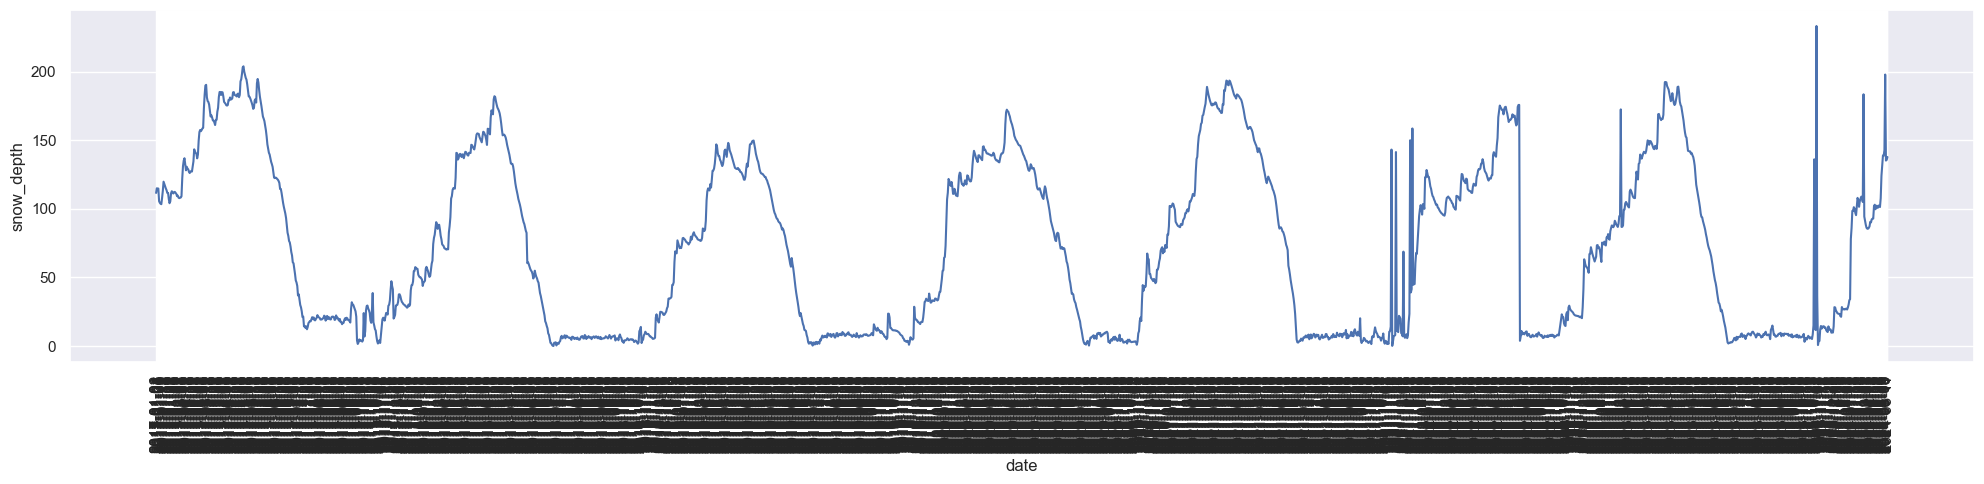

In [156]:
# this shows decrease in snow amount over time.
# importantly, Lodge's snow_depth never reaches 0, especially in 2017.
# This kinda makes things sucky, but experimentally 25 inches seems to work well-ish
ax: plt.Axes = sb.lineplot(weather[weather.place == "Lodge"], x="date", y="snow_depth")
ax.figure.set_size_inches(w=20, h=5)
plt.xticks(rotation=90)
plt.tight_layout()